In [27]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision #для преобразования информации, хранящейся в файлах изображений.
import torchvision.transforms as transforms

torch.manual_seed(111)

In [28]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

временное закрепление генератора случайных чисел

In [29]:
torch.manual_seed(111)

In [30]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])#  преобразует данные в тензор PyTorch и преобразует диапазон тензорных коэффициентов

Аргументы transforms.Normalize() представляют собой это два кортежа (M₁, ..., Mₙ) и (S₁, ..., Sₙ), где n соответствует количеству каналов в изображении. Картинки в градациях серого, как в наборе данных MNIST, имеют лишь один канал. Для каждого i-го канала изображения transforms.Normalize() вычитает Mᵢ из коэффициентов и делит результат на Sᵢ.

In [31]:
train_set = torchvision.datasets.FashionMNIST(
    root="./", train=True, download=True, transform=transform)

In [32]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True)

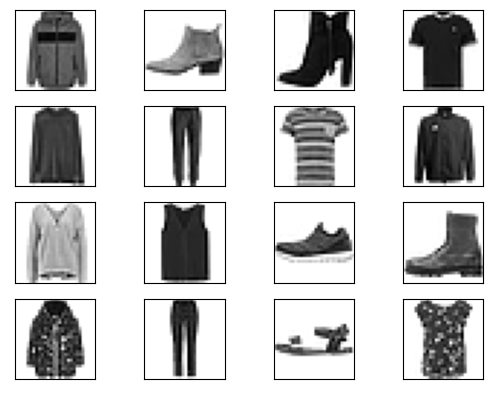

In [33]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

Векторизация происходит в первой строке метода forward() – вызов x.view() преобразует форму входного тензора. Исходная форма тензора 𝑥x – 32 × 1 × 28 × 28, где 32 – размер партии. После преобразования форма 𝑥x становится равной 32 × 784, причем каждая строка представляет коэффициенты изображения обучающего набора.

In [34]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [35]:
discriminator = Discriminator().to(device=device)

In [36]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

In [37]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [38]:
for epoch in range(num_epochs):
    torch.save(generator, './q1')
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Данные для тренировки дискриминатора
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device)
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels))

        # Обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device)

        # Обучение генератора
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Показываем loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")


Epoch: 0 Loss D.: 0.5729575157165527
Epoch: 0 Loss G.: 0.47836142778396606
Epoch: 1 Loss D.: 0.025855494663119316
Epoch: 1 Loss G.: 4.39849853515625
Epoch: 2 Loss D.: 0.05647599324584007
Epoch: 2 Loss G.: 4.683253765106201
Epoch: 3 Loss D.: 0.10642032325267792
Epoch: 3 Loss G.: 2.7860007286071777
Epoch: 4 Loss D.: 0.17096789181232452
Epoch: 4 Loss G.: 3.3981196880340576
Epoch: 5 Loss D.: 0.23286528885364532
Epoch: 5 Loss G.: 2.79556941986084
Epoch: 6 Loss D.: 0.25755149126052856
Epoch: 6 Loss G.: 2.094707727432251
Epoch: 7 Loss D.: 0.35431796312332153
Epoch: 7 Loss G.: 2.1500742435455322
Epoch: 8 Loss D.: 0.531289279460907
Epoch: 8 Loss G.: 1.207592487335205
Epoch: 9 Loss D.: 0.405120313167572
Epoch: 9 Loss G.: 1.2881829738616943
Epoch: 10 Loss D.: 0.47038179636001587
Epoch: 10 Loss G.: 1.475577712059021
Epoch: 11 Loss D.: 0.6276702880859375
Epoch: 11 Loss G.: 1.1980925798416138
Epoch: 12 Loss D.: 0.5829021334648132
Epoch: 12 Loss G.: 1.0508215427398682
Epoch: 13 Loss D.: 0.67251753807

In [39]:
#generator = torch.load('./q2')

In [40]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

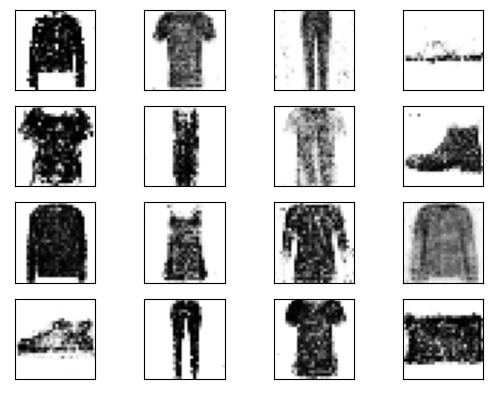

In [41]:
generated_samples = generated_samples.cpu().detach()

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])